# Setup and Preprocessing

In [11]:
# Export requirements.txt for only the packages used in this notebook
# pip install pipreqs
# !pipreqs --force .
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd, glob, os, sys, win32com.client, pythoncom, numpy as np, re, seaborn as sns, matplotlib.pyplot as plt, warnings, time, pickle
from filesplit.split import Split
from filesplit.merge import Merge

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
set_config(display='diagram')
# dir_path = os.path.dirname(os.path.realpath(sys.argv[0])) + "\\"
dir_path = os.getcwd() + "\\"

def set_options(xl, option):
    try:
        xl.Visible = option
        xl.ScreenUpdating = option
        xl.DisplayAlerts = option
        xl.EnableEvents = option
    except: 
        pass

def convert(file):
    file = os.path.splitext(file)[0]
    print('Converting {}...'.format(file))
    xl=win32com.client.Dispatch("Excel.Application",pythoncom.CoInitialize())
    set_options(xl, False)
    
    # check if file with .csv exists
    if not os.path.isfile(dir_path + file + '.csv'):
        try:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsx',ReadOnly=1)
        except:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsb',ReadOnly=1)  
        xl.ActiveWorkbook == wb
        
        #6 means csv
        wb.SaveAs(Filename= dir_path + file + '.csv', FileFormat='6') 
        set_options(xl, True)
        wb.Close(True)
        xl.Application.Quit()
        wb=xl=None
    
    df = pd.read_csv(dir_path + file + '.csv', low_memory = False, encoding='ISO-8859-1')
    df.to_pickle(dir_path + file + '.pkl')
    
    return file + '.pkl'

def read(i):
    try: 
        pkl = glob.glob(os.path.join('*{0}*.pkl'.format(i)))[0]
    except: 
        pkl = convert(glob.glob(os.path.join('*{0}*'.format(i)))[0])
    df = pd.read_pickle(dir_path + pkl)
    return df

# Custom function to store models
def pickle_split(filename, model):
    file = filename + '.mgz'
    pickle.dump(model, open(file, 'wb'))

    # Check file size
    print('File Size: {:.2f} {}'.format(os.path.getsize(file)/1000000, 'MB'))

    # Split stack.mgz into 99 MB parts using filesplit
    split = Split(inputfile=file, outputdir='.')
    split.manfilename = filename
    split.bysize(size=100000000)
    os.remove(file)

def merge_pickle(filename):
    # Merge the files back together
    filepath = filename + '.mgz'
    merge = Merge(inputdir='.', outputdir='.', outputfilename=filepath)
    merge.manfilename = filename
    merge.merge()

    # Load the model
    file = pickle.load(open(filepath, 'rb'))
    os.remove(filepath)
    return file

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YongLe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\YongLe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
# Pickle dataset, delete resume.pkl if you are facing issues
i = "Resume"
df = read(i)

df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [13]:
# Remove Resume_html and ID
df.drop(['Resume_html', 'ID'], axis=1, inplace=True)
df.columns = ['text', 'label']

df.head()

,text,label
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [14]:
# Clean text
df['text'] = [re.sub('</?([a-z]+)>', ' ', x) for x in df['text']] 
df['text'] = [re.sub('<[^>]*>', '', x) for x in df['text']] 
df['text'] = [re.sub('\s+', ' ', x) for x in df['text']] 
df['text'] = [x.lower() for x in df['text']] # lowercase

df.head()

,text,label
0,hr administrator/marketing associate hr admin...,HR
1,"hr specialist, us hr operations summary versa...",HR
2,hr director summary over 20 years experience ...,HR
3,"hr specialist summary dedicated, driven, and ...",HR
4,hr manager skill highlights hr skills hr depa...,HR


In [5]:
# Define X and y
X = df['text']
y = df['label']

In [6]:
# Create a RandomizedSearchCV function to find the best parameters/hyperparameters tuning
def RandomizedSearchCV_function(regressor, parameters, tune=True, X_train=None, y_train=None):
    start_time = time.time()
    # Define column transformer and pipeline
    pipeline = Pipeline([
        ('vect', TfidfVectorizer(analyzer='word',strip_accents=None, encoding='utf-8',preprocessor=None,ngram_range=(1, 2),token_pattern=r'(?u)\b\w[\w-]*\w\b|\b\w+\b', stop_words='english')),
        ('clf', regressor)
    ])

    # Create a randomized search cross validation and no verbose
    if tune:
        random_search = HalvingRandomSearchCV(pipeline, parameters, scoring='f1_weighted', n_jobs=-1, random_state=2022, verbose=0, factor=4, max_resources=1987, min_resources=1987//4)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        print('Best score for {}: {}'.format(regressor.__class__.__name__, random_search.best_score_))
        print('Best parameters: {}'.format(random_search.best_params_))
    else:
        best_model = pipeline.fit(X_train, y_train)
        print('Score: {}: {}'.format(regressor.__class__.__name__, best_model.score(X_train, y_train)))
        print('Parameters: {}'.format({k: v for k, v in best_model.get_params().items() if k in parameters}))
        
    print('Time taken: {:.2f} seconds'.format(time.time() - start_time))
    print('='*50)
    return best_model[:2]

# Create a custom function to show performance and importance of features
def show_performance(model_name, model, mode="full", X_test=None, y_test=None):
    # Predict the test set
    y_pred = model.predict(X_test)

    # Show scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('Model: {}'.format(model_name))
    print('Precision score: {:.2f}'.format(precision))
    print('Recall score: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))

    # Full mmode
    if mode == "full":
        print('Classification report of {} is:'.format(model_name))
        print(classification_report(y_test, y_pred))
        plt.figure(figsize=(10, 10))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues_r')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        all_sample_title = 'Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred))
        plt.title(all_sample_title, size=15)
        plt.show()
        # ROC AUC score if model has predict_proba method
        if hasattr(model, 'predict_proba'):
            print('ROC AUC score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')))
        else:
            confidence = model.decision_function(X_test)
            confidence = confidence / np.sum(confidence, axis=1, keepdims=True)
            roc_auc_score(y_test, confidence, multi_class='ovr')

        # Get the feature importance
        if hasattr(model, 'final_estimator_'):
            feature_importance = model.final_estimator_.coef_
            models = model.named_estimators_
            classes = model.classes_
            importance = pd.DataFrame(feature_importance, index=classes)
            return importance
        elif hasattr(model.steps[1][1], 'coef_'):
            feature_importance = model.steps[1][1].coef_
        elif hasattr(model.steps[1][1], 'feature_importances_'):
            feature_importance = model.steps[1][1].feature_importances_

        # Normalize the importance to 2dp
        try:
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            importance = pd.DataFrame({'importance_'+model_name: feature_importance[0]}, index=model.steps[0][1].get_feature_names())
            importance = importance.sort_values('importance_'+model_name, ascending=False)
            # Show the feature importance dataframe
            print('Feature importance of {} is:'.format(model_name))
            print(importance)
        except:
            print('No feature importance for {}'.format(model_name))
    print('='*50)
    
    return model_name, precision, recall, f1


def bulk_train(X_train=None, y_train=None):
    best_log = ["LogisticRegression",RandomizedSearchCV_function(LogisticRegression(), {'clf__C': (0.01, 0.1, 1, 10, 100),'clf__penalty': ('l1', 'l2'),'clf__solver': ('liblinear', 'saga')}, tune=True, X_train=X_train, y_train=y_train)]
    best_sgd = ["SGDClassifier",RandomizedSearchCV_function(SGDClassifier(), {'clf__alpha': (0.0001, 0.0005, 0.00001),'clf__penalty': ('l1', 'l2',), 'clf__n_jobs': (-1,), 'clf__n_iter_no_change': (5, 10, 15, 20)}, tune=True, X_train=X_train, y_train=y_train)]
    best_et = ["ExtraTreesClassifier",RandomizedSearchCV_function(ExtraTreesClassifier(), {'clf__n_estimators': np.arange(10,30), 'clf__bootstrap': (True, False), 'clf__n_jobs': (-1,), 'clf__max_features': (None,), 'clf__min_samples_split': (2,), 'clf__min_samples_leaf': (2, 3)}, tune=True, X_train=X_train, y_train=y_train)]
    best_xgb = ["XGBClassifier",RandomizedSearchCV_function(xgb.XGBClassifier(), {'clf__n_estimators': np.arange(10,30), 'clf__learning_rate': np.arange(0.1,0.2), 'clf__n_jobs': (-1,), 'clf__lambda': np.arange(0.5,1,0.1), 'clf__alpha': np.arange(0.5,1,0.1)}, tune=True, X_train=X_train, y_train=y_train)]
    best_lgbm = ["LGBMClassifier",RandomizedSearchCV_function(LGBMClassifier(), {'clf__verbose': (-1,), 'clf__n_jobs': (-1,), 'clf__reg_alpha': np.arange(0.1,1,0.1), 'clf__reg_lambda': np.arange(0.1,1,0.1), 'clf__max_depth': (-1,), 'clf__silent': (True,), 'clf__force_col_wise': (True,), 'clf__metric': ('multi_logloss',), 'clf__objective': ('multiclass',)}, tune=True, X_train=X_train, y_train=y_train)]

    best_models = [best_log, best_sgd, best_et, best_xgb, best_lgbm]
    return best_models

# All Models

In [7]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022, stratify=y)

best_models = bulk_train(X_train=X_train, y_train=y_train)

Best score for LogisticRegression: 0.7727985243121244
Best parameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 10}
Time taken: 73.29 seconds
Best score for SGDClassifier: 0.7621431213314811
Best parameters: {'clf__penalty': 'l1', 'clf__n_jobs': -1, 'clf__n_iter_no_change': 10, 'clf__alpha': 0.0001}
Time taken: 19.94 seconds
Best score for ExtraTreesClassifier: 0.7371890639276202
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 24, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__bootstrap': True}
Time taken: 62.14 seconds
Best score for XGBClassifier: 0.7299486508326695
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 22, 'clf__learning_rate': 0.1, 'clf__lambda': 0.5, 'clf__alpha': 0.6}
Time taken: 138.73 seconds
Best score for LGBMClassifier: 0.7699767092479186
Best parameters: {'clf__verbose': -1, 'clf__silent': True, 'clf__reg_lambda': 0.4, 'clf__reg_alpha': 0.1, 'clf__objective': 'multiclass', 'clf__n_j

In [8]:
# Create a dataframe to show the performance of the models
performance = [show_performance(*model, mode='lite', X_test=X_test, y_test=y_test) for model in best_models]
df_performance = pd.DataFrame(performance, columns=['Model', 'Precision', 'Recall', 'F1'])
df_performance.sort_values('F1', ascending=False)

Model: LogisticRegression
Precision score: 0.80
Recall score: 0.80
F1 score: 0.79
Model: SGDClassifier
Precision score: 0.81
Recall score: 0.81
F1 score: 0.80
Model: ExtraTreesClassifier
Precision score: 0.75
Recall score: 0.75
F1 score: 0.74
Model: XGBClassifier
Precision score: 0.75
Recall score: 0.75
F1 score: 0.74
Model: LGBMClassifier
Precision score: 0.78
Recall score: 0.80
F1 score: 0.79


,Model,Precision,Recall,F1
1,SGDClassifier,0.814063,0.810865,0.804742
0,LogisticRegression,0.800068,0.798793,0.794821
4,LGBMClassifier,0.783208,0.796781,0.786651
3,XGBClassifier,0.751918,0.746479,0.743356
2,ExtraTreesClassifier,0.751070,0.750503,0.735126


# Stacking Classifier

In [9]:
def stacking(df, best_models, threshold=0.75, X_test=None, y_test=None):
    # Create a stacking classifier
    stack = StackingClassifier(estimators=[best_models[i] for i in df[df['F1'] >= threshold].index], n_jobs=-1, passthrough=False, verbose=1)
    stack.fit(X_train, y_train)

    # Show the performance of the stacking classifier
    imp_stack = show_performance('StackingClassifier', stack, mode='full', X_test=X_test, y_test=y_test)

    # imp_stack columns are the combination of model-class. 
    # This is a guess, i am not sure if this is the correct way to do it but 168 columns divided by 7 models is 24, which is the number of classes
    columns = [m+'-'+ c for m in stack.named_estimators_ for c in stack.classes_]
    imp_stack.columns = columns

    # Apply MinMaxScaler to the dataframe
    imp_minmax = pd.DataFrame(MinMaxScaler().fit_transform(imp_stack), columns=imp_stack.columns, index=imp_stack.index)

    # Collapse the dataframe to get the importance of each model
    imp_minmax = imp_minmax.sum(axis=0).reset_index()
    imp_minmax.columns = ['Model', 'Importance']

    # Sum up importance of each model before the dash
    imp_minmax['Model'] = imp_minmax['Model'].apply(lambda x: x.split('-')[0])
    imp_minmax = imp_minmax.groupby('Model').sum().reset_index()
    print(imp_minmax.sort_values('Importance', ascending=False))

    return stack, imp_minmax

In [10]:
stack, imp_minmax = stacking(df_performance, best_models, 0.75, X_test=X_test, y_test=y_test)

NameError: name 'df_performance' is not defined

# Voting Classifier

In [11]:
def voting(df, best_models, threshold=0.75, X_test=None, y_test=None):
    # Create a Soft Voting Classifier
    vote = VotingClassifier(estimators=[best_models[i] for i in df[df['F1'] >= threshold].index], n_jobs=-1, verbose=1)
    vote.fit(X_train, y_train)

    # Show the performance of the voting classifier
    imp_vote = show_performance('VotingClassifier', vote, mode='lite', X_test=X_test, y_test=y_test)

    return vote, imp_vote

In [12]:
vote, imp_vote = voting(df_performance, best_models, 0.75, X_test=X_test, y_test=y_test)

Model: VotingClassifier
Precision score: 0.82
Recall score: 0.82
F1 score: 0.82


# Repeat for Lemmatized and Stemmed Text

In [13]:
# stem the text column into a new column:
stemmer = PorterStemmer()
df['text_stemmed'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

# lemma the text column into a new column:
lemmatizer = WordNetLemmatizer()
df['text_lemmatized'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(y) for y in x.split(' ')]))

X_stemmed = df['text_stemmed']
X_lemmatized = df['text_lemmatized']

In [14]:
X_stemmed_train, X_stemmed_test, y_stemmed_train, y_stemmed_test = train_test_split(X_stemmed, y, test_size=0.2, random_state=2022, stratify=y)

best_models_2 = bulk_train(X_train=X_stemmed_train, y_train=y_stemmed_train)

Best score for LogisticRegression: 0.7479932281598414
Best parameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 10}
Time taken: 65.06 seconds
Best score for SGDClassifier: 0.72975074951034
Best parameters: {'clf__penalty': 'l1', 'clf__n_jobs': -1, 'clf__n_iter_no_change': 10, 'clf__alpha': 0.0001}
Time taken: 18.92 seconds
Best score for ExtraTreesClassifier: 0.7156344751743746
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 29, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__bootstrap': True}
Time taken: 66.58 seconds
Best score for XGBClassifier: 0.6979231242506354
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 22, 'clf__learning_rate': 0.1, 'clf__lambda': 0.5, 'clf__alpha': 0.6}
Time taken: 136.81 seconds
Best score for LGBMClassifier: 0.7494502394917901
Best parameters: {'clf__verbose': -1, 'clf__silent': True, 'clf__reg_lambda': 0.7000000000000001, 'clf__reg_alpha': 0.5, 'clf__objective': 'multiclas

In [15]:
performance_2 = [show_performance(*model, mode='lite', X_test=X_stemmed_test, y_test=y_stemmed_test) for model in best_models_2]
df_performance_2 = pd.DataFrame(performance_2, columns=['Model', 'Precision', 'Recall', 'F1'])
df_performance_2.sort_values('F1', ascending=False)

Model: LogisticRegression
Precision score: 0.79
Recall score: 0.79
F1 score: 0.79
Model: SGDClassifier
Precision score: 0.78
Recall score: 0.78
F1 score: 0.77
Model: ExtraTreesClassifier
Precision score: 0.76
Recall score: 0.77
F1 score: 0.76
Model: XGBClassifier
Precision score: 0.79
Recall score: 0.78
F1 score: 0.77
Model: LGBMClassifier
Precision score: 0.80
Recall score: 0.79
F1 score: 0.79


,Model,Precision,Recall,F1
0,LogisticRegression,0.794601,0.794769,0.789837
4,LGBMClassifier,0.800411,0.794769,0.786282
3,XGBClassifier,0.788270,0.778672,0.773280
1,SGDClassifier,0.781279,0.778672,0.771424
2,ExtraTreesClassifier,0.762004,0.774648,0.760146


Model: StackingClassifier
Precision score: 0.47
Recall score: 0.38
F1 score: 0.36
Classification report of StackingClassifier is:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.67      0.25      0.36        24
              ADVOCATE       0.33      0.08      0.13        24
           AGRICULTURE       0.25      0.31      0.28        13
               APPAREL       0.26      0.79      0.39        19
                  ARTS       0.17      0.14      0.15        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.58      0.58      0.58        24
               BANKING       0.31      0.74      0.44        23
                   BPO       0.50      0.25      0.33         4
  BUSINESS-DEVELOPMENT       0.08      0.25      0.12        24
                  CHEF       0.83      0.79      0.81        24
          CONSTRUCTION       1.00      0.18      0.31        22
            CONSULTANT       0.22    

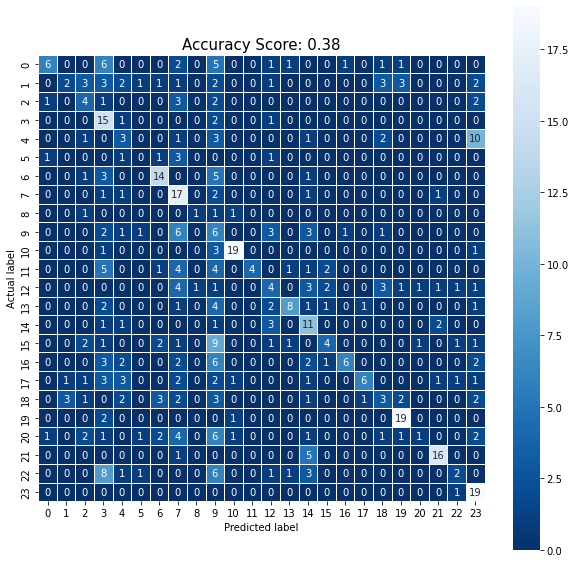

ROC AUC score: 0.81
                Model  Importance
2       XGBClassifier  114.053817
0      LGBMClassifier  104.773226
1  LogisticRegression   96.232590


In [16]:
stack_2, imp_minmax_2 = stacking(df_performance_2, best_models_2, 0.773, X_test=X_stemmed_test, y_test=y_stemmed_test)

In [17]:
vote_2, imp_vote_2 = voting(df_performance_2, best_models_2, 0.773, X_test=X_stemmed_test, y_test=y_stemmed_test)

Model: VotingClassifier
Precision score: 0.45
Recall score: 0.38
F1 score: 0.36


In [18]:
X_lemmatized_train, X_lemmatized_test, y_lemmatized_train, y_lemmatized_test = train_test_split(X_lemmatized, y, test_size=0.2, random_state=2022, stratify=y)

best_models_3 = bulk_train(X_train=X_lemmatized_train, y_train=y_lemmatized_train)

Best score for LogisticRegression: 0.761641529106005
Best parameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 10}
Time taken: 70.06 seconds
Best score for SGDClassifier: 0.7499165074439308
Best parameters: {'clf__penalty': 'l1', 'clf__n_jobs': -1, 'clf__n_iter_no_change': 10, 'clf__alpha': 0.0001}
Time taken: 19.21 seconds
Best score for ExtraTreesClassifier: 0.7313940877598685
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 24, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_features': None, 'clf__bootstrap': True}
Time taken: 58.06 seconds
Best score for XGBClassifier: 0.7111223244244078
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 10, 'clf__learning_rate': 0.1, 'clf__lambda': 0.6, 'clf__alpha': 0.7}
Time taken: 80.05 seconds
Best score for LGBMClassifier: 0.7604983556981553
Best parameters: {'clf__verbose': -1, 'clf__silent': True, 'clf__reg_lambda': 0.9, 'clf__reg_alpha': 0.5, 'clf__objective': 'multiclass', 'clf__n_job

In [19]:
performance_3 = [show_performance(*model, mode='lite', X_test=X_lemmatized_test, y_test=y_lemmatized_test) for model in best_models_3]
df_performance_3 = pd.DataFrame(performance_3, columns=['Model', 'Precision', 'Recall', 'F1'])
df_performance_3.sort_values('F1', ascending=False)

Model: LogisticRegression
Precision score: 0.81
Recall score: 0.81
F1 score: 0.81
Model: SGDClassifier
Precision score: 0.81
Recall score: 0.80
F1 score: 0.80
Model: ExtraTreesClassifier
Precision score: 0.74
Recall score: 0.75
F1 score: 0.73
Model: XGBClassifier
Precision score: 0.75
Recall score: 0.74
F1 score: 0.73
Model: LGBMClassifier
Precision score: 0.80
Recall score: 0.80
F1 score: 0.79


,Model,Precision,Recall,F1
0,LogisticRegression,0.808007,0.808853,0.805413
1,SGDClassifier,0.805387,0.804829,0.796668
4,LGBMClassifier,0.802353,0.798793,0.791855
3,XGBClassifier,0.745921,0.738431,0.734100
2,ExtraTreesClassifier,0.735303,0.750503,0.733504


Model: StackingClassifier
Precision score: 0.73
Recall score: 0.76
F1 score: 0.73
Classification report of StackingClassifier is:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.95      0.83      0.89        24
              ADVOCATE       0.71      0.83      0.77        24
           AGRICULTURE       0.35      0.46      0.40        13
               APPAREL       0.52      0.68      0.59        19
                  ARTS       0.44      0.19      0.27        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.88      0.88      0.88        24
               BANKING       0.71      0.74      0.72        23
                   BPO       1.00      0.25      0.40         4
  BUSINESS-DEVELOPMENT       0.84      0.88      0.86        24
                  CHEF       0.95      0.79      0.86        24
          CONSTRUCTION       0.88      1.00      0.94        22
            CONSULTANT       0.68    

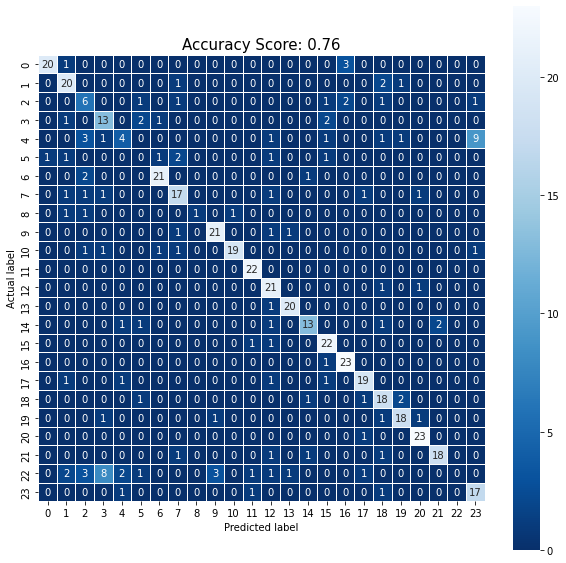

ROC AUC score: 0.96
                Model  Importance
2       SGDClassifier  216.002444
1  LogisticRegression  158.217473
0      LGBMClassifier  120.455428


In [20]:
stack_3, imp_minmax_3 = stacking(df_performance_3, best_models_3, 0.79, X_test=X_lemmatized_test, y_test=y_lemmatized_test)

In [21]:
vote_3, imp_vote_3 = voting(df_performance_3, best_models_3, 0.79, X_test=X_lemmatized_test, y_test=y_lemmatized_test)

Model: VotingClassifier
Precision score: 0.77
Recall score: 0.77
F1 score: 0.74


In [22]:
# # Load the model
# import mgzip
# stack = merge_pickle('stack')
# vote = merge_pickle('vote')

In [23]:
# # Save the model
# pickle_split('stack', stack)
# pickle_split('vote', vote)

# Store Raw Stacking Classifier 

In [5]:
# Load stack.mgz shortcut if you already merged beforehand
import pickle, os, pandas as pd
from sklearn.preprocessing import MinMaxScaler
cwd = os.getcwd()
stack = pickle.load(open(cwd + '/stack.mgz', 'rb'))

feature_importance = stack.final_estimator_.coef_
classes = stack.classes_
named_estimators = stack.named_estimators_

importance = pd.DataFrame(feature_importance, index=classes)
columns = [m+'-'+ c for m in named_estimators for c in classes]
importance.columns = columns

# Apply MinMaxScaler to the dataframe
imp_minmax = pd.DataFrame(MinMaxScaler().fit_transform(importance), columns=importance.columns, index=importance.index)

# Collapse the dataframe to get the importance of each model
imp_minmax = imp_minmax.sum(axis=0).reset_index()
imp_minmax.columns = ['Model', 'Importance']

# Sum up importance of each model before the dash
imp_minmax['Model'] = imp_minmax['Model'].apply(lambda x: x.split('-')[0])
imp_minmax = imp_minmax.groupby('Model').sum().reset_index()
imp_minmax.sort_values('Importance', ascending=False)

# Normalise importance
imp_minmax['Importance'] = imp_minmax['Importance'].apply(lambda x: x/imp_minmax['Importance'].sum())

# Save the dataframe
imp_minmax.to_csv('imp_minmax.csv', index=False)

# Combining Feature Importances
We dont have a one-vs-all approach for trees, can't seem to combine it with the stacking classifier [Suggest we just remove tree models]

In [7]:
# What are the features that are most important to the model for each class
df_stack = []
for name in stack.named_estimators_:
    print(name)
    # Create a dataframe
    if hasattr(stack.named_estimators_[name]['clf'], 'feature_importances_'):
        pass
    else: 
        df = pd.DataFrame(stack.named_estimators_[name]['clf'].coef_, columns=stack.named_estimators_[name]['vect'].get_feature_names_out(), index=stack.classes_)
        df = df.T
        df.columns = stack.classes_
        # Multiply the coefficients by the importance of the model from imp_minmax
        df = df.mul(imp_minmax[imp_minmax['Model']==name]['Importance'].values[0], axis=0)
        # Normalise numbers using minmax scaler
        df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
        df_stack.append(df)

# Concatenate the dataframes
df_stack = pd.concat(df_stack)

df_stack_final = []
# Get the top 10 features for each class
for c in df_stack.columns:
    print(c)
    df_stack_final.append(df_stack[~df_stack.index.duplicated(keep='first')][c].sort_values(ascending=False).head(10))

# Concatenate the dataframes
df_stack_final = pd.concat(df_stack_final, axis=1)
df_stack_final.to_csv('df_stack.csv')

# features = stack.named_estimators_['ExtraTreesClassifier']['clf'].feature_importances_
# feature_names = stack.named_estimators_['ExtraTreesClassifier']['vect'].get_feature_names()
# df = pd.DataFrame(features, index=feature_names, columns=['Importance'])
# df.sort_values('Importance', ascending=False).head(10)

LogisticRegression
SGDClassifier
LGBMClassifier
ACCOUNTANT
ADVOCATE
AGRICULTURE
APPAREL
ARTS
AUTOMOBILE
AVIATION
BANKING
BPO
BUSINESS-DEVELOPMENT
CHEF
CONSTRUCTION
CONSULTANT
DESIGNER
DIGITAL-MEDIA
ENGINEERING
FINANCE
FITNESS
HEALTHCARE
HR
INFORMATION-TECHNOLOGY
PUBLIC-RELATIONS
SALES
TEACHER


# For Team:
Wishlist for potential upside:
1. Stemming/Lemmatisation DONE
2. Generate more features such as length of resume
3. Try combining features from trees (currently taking a multi-class approach hence array doesn't separate out to classes) to interpret stacking classifier
4. Try soft voting or weighted hard voting
5. Highlighting individual resume pdfs on frontend, providing users with insights